In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms
import torch.nn.functional as F

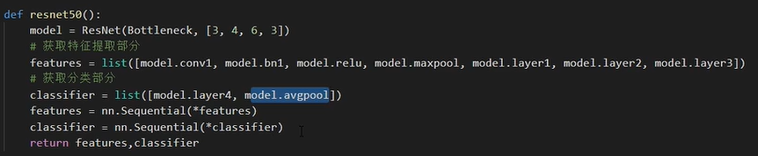
### 模型，将主干特征提取和分类层网络分割

In [2]:
resnet_model = models.resnet18(pretrained=True) 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


In [4]:
for name in resnet_model._modules.items():
    print(name)  
# resnet_model.layer1[0].conv1
# Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# affine: 布尔值,当设为true,给该层添加可学习的仿射变换参数。 track_running_stats:布尔值,当设为true,记录训练过程中的均值和方差

('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kerne

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [8]:
# pretrained 设置为 True，会自动下载模型 所对应权重，并加载到模型中
# 也可以自己下载 权重，然后 load 到 模型中，源码中有 权重的地址。
 
# 假设 我们的 分类任务只需要 分 100 类，那么我们应该做的是
# 1. 查看 resnet 的源码
# 2. 看最后一层的 名字是啥 （在 resnet 里是 self.fc = nn.Linear(512 * block.expansion, num_classes)）
# 3. 在外面替换掉这个层
resnet_model.fc= nn.Linear(in_features=512, out_features=100)
 
# 这样就 哦了，修改后的模型除了输出层的参数是 随机初始化的，其他层都是用预训练的参数初始化的。
 
# 如果只想训练 最后一层的话，应该做的是：
# 1. 将其它层的参数 requires_grad 设置为 False
# 2. 构建一个 optimizer， optimizer 管理的参数只有最后一层的参数
# 3. 然后 backward， step 就可以了
 
# 这一步可以节省大量的时间，因为多数的参数不需要计算梯度
# for para in list(resnet_model.parameters())[:-2]:
#     para.requires_grad=False 
 
# optimizer = optim.SGD(params=[resnet_model.fc.weight, resnet_model.fc.bias], lr=1e-3)

# 当我们需要对整个网络进行微调训练时，可以对变动比较小的网络结构赋予较小的学习率，对新添加的网络结构加入较大的学习率
ignored_params = list(map(id, resnet_model.fc.parameters()))  # id 表示key值，即当前model.fc.parameters()里的参数的key值为model.fc.parameters()；
base_params = filter(lambda p: id(p) not in ignored_params,  # filter 内置函数，用于过滤掉不符合条件的数据，并返回新列表；
                     resnet_model.parameters())
 
optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': resnet_model.fc.parameters(), 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)

In [18]:
# 模型保存方式1，保存模型参数
path = './resnet_model.pt'
torch.save(resnet_model.state_dict(),path)

net1 = models.resnet18(pretrained=False)
net1.fc= nn.Linear(in_features=512, out_features=100)

# net1.load_state_dict(torch.load(path)) # 方式一

model_params = torch.load(path)    # 方式二
for k,v in model_params.items():  
    if k in net1.state_dict().keys():
        net1.state_dict()[k] = v

In [17]:
# 模型保存方式2，保存模型结构和参数
path = './resnet_model2.pt'
torch.save(resnet_model,path)

net2 = torch.load(path)

In [19]:
# 如果模型的key值和在大数据集上训练时的key值是一样的
model_dict = net1.state_dict()
 
pretrained_dict = torch.load(path)
 # 1. filter out unnecessary keys
diff = {k: v for k, v in model_dict.items() if \
            k in pretrained_dict and pretrained_dict[k].size() == v.size()}
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].size() == v.size()}
pretrained_dict.update(diff)
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict)
# 3. load the new state dict
net1.load_state_dict(model_dict)

<All keys matched successfully>

In [22]:
# 如果模型的key值和在大数据集上训练时的key值是不一样的，但是顺序是一样的
model_dict = net1.state_dict()
 
pretrained_dict = torch.load(path)
keys = []
for k,v in pretrained_dict.items():
    keys.append(k)
i = 0
for k,v in model_dict.items():
    if v.size() == pretrained_dict[keys[i]].size():
        print(k, ',', keys[i])
        model_dict[k] = pretrained_dict[keys[i]]
    i = i + 1
net1.load_state_dict(model_dict)

conv1.weight , conv1.weight
bn1.weight , bn1.weight
bn1.bias , bn1.bias
bn1.running_mean , bn1.running_mean
bn1.running_var , bn1.running_var
bn1.num_batches_tracked , bn1.num_batches_tracked
layer1.0.conv1.weight , layer1.0.conv1.weight
layer1.0.bn1.weight , layer1.0.bn1.weight
layer1.0.bn1.bias , layer1.0.bn1.bias
layer1.0.bn1.running_mean , layer1.0.bn1.running_mean
layer1.0.bn1.running_var , layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked , layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight , layer1.0.conv2.weight
layer1.0.bn2.weight , layer1.0.bn2.weight
layer1.0.bn2.bias , layer1.0.bn2.bias
layer1.0.bn2.running_mean , layer1.0.bn2.running_mean
layer1.0.bn2.running_var , layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked , layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight , layer1.1.conv1.weight
layer1.1.bn1.weight , layer1.1.bn1.weight
layer1.1.bn1.bias , layer1.1.bn1.bias
layer1.1.bn1.running_mean , layer1.1.bn1.running_mean
layer1.1.bn1.running_var , l

<All keys matched successfully>

In [33]:
s1 = range(1,100)
s2 = list(map(lambda p: p ** 2,s1))
s3 = list(map(str,s1))
s2 = list(map(lambda p: p ** 2 if p % 2 == 0 else p,s1))
s4 = [i if i % 2 == 0 else i+1 for i in range(1,100)]
s5 = list(filter(lambda p: p < 50,s4))
print(s2)
print(s4)
print(s5)

[1, 4, 3, 16, 5, 36, 7, 64, 9, 100, 11, 144, 13, 196, 15, 256, 17, 324, 19, 400, 21, 484, 23, 576, 25, 676, 27, 784, 29, 900, 31, 1024, 33, 1156, 35, 1296, 37, 1444, 39, 1600, 41, 1764, 43, 1936, 45, 2116, 47, 2304, 49, 2500, 51, 2704, 53, 2916, 55, 3136, 57, 3364, 59, 3600, 61, 3844, 63, 4096, 65, 4356, 67, 4624, 69, 4900, 71, 5184, 73, 5476, 75, 5776, 77, 6084, 79, 6400, 81, 6724, 83, 7056, 85, 7396, 87, 7744, 89, 8100, 91, 8464, 93, 8836, 95, 9216, 97, 9604, 99]
[2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 16, 16, 18, 18, 20, 20, 22, 22, 24, 24, 26, 26, 28, 28, 30, 30, 32, 32, 34, 34, 36, 36, 38, 38, 40, 40, 42, 42, 44, 44, 46, 46, 48, 48, 50, 50, 52, 52, 54, 54, 56, 56, 58, 58, 60, 60, 62, 62, 64, 64, 66, 66, 68, 68, 70, 70, 72, 72, 74, 74, 76, 76, 78, 78, 80, 80, 82, 82, 84, 84, 86, 86, 88, 88, 90, 90, 92, 92, 94, 94, 96, 96, 98, 98, 100]
[2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 16, 16, 18, 18, 20, 20, 22, 22, 24, 24, 26, 26, 28, 28, 30, 30, 32, 32, 34, 34, 36, 36, 38,